#Entrega final IEFI Aprendizaje Automatico 1: Caso Titanic 📝📊📚

---



In [1]:
#visualizacion y limpieza
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve

#modelos y metricas
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler


#guardado
import pickle
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/IES/Segundo semestre/Aprendizaje automatico I/Parcial 1 - TITANIC/Titanic/Titanic-Dataset.csv')

Mounted at /content/drive


#Analitica 📊📈

In [3]:
#veo los porcentajes de hombres y mujeres que sobrevivieron

mujeres = df.loc[df.Sex == 'female']["Survived"]
supervivencia_mujeres = sum(mujeres)/len(mujeres)
hombres = df.loc[df.Sex == 'male']["Survived"]
supervivencia_hombres = sum(hombres)/len(hombres)

print(f"% de mujeres que sobrevivieron: % {supervivencia_mujeres}")
print(f"% de hombres que sobrevivieron: % {supervivencia_hombres}")

% de mujeres que sobrevivieron: % 0.7420382165605095
% de hombres que sobrevivieron: % 0.18890814558058924


In [4]:
# Contar el número de mujeres y hombres que tengo en mi set de datos de Train
mujeres_totales = df.loc[df['Sex'] == 'female'].shape[0]
hombres_totales = df.loc[df['Sex'] == 'male'].shape[0]

# Imprimir el resultado
print(f"Mujeres que abordaron: {mujeres_totales}")
print(f"Hombres que abordaron: {hombres_totales}")


Mujeres que abordaron: 314
Hombres que abordaron: 577


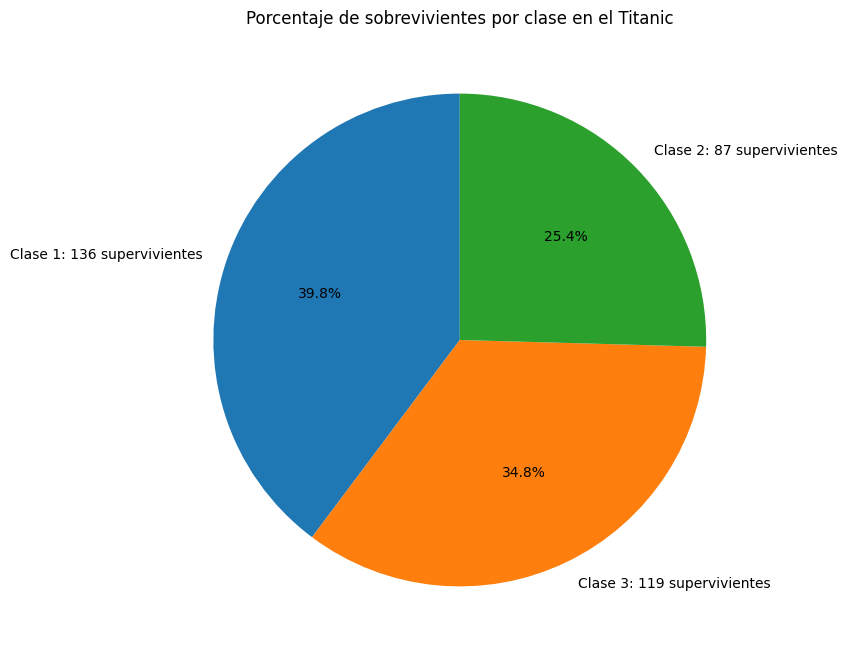

In [5]:
supervivientes = df[df['Survived'] == 1]

clase_supervivientes = supervivientes['Pclass'].value_counts()

labels = []
for i in clase_supervivientes.index:
    labels.append(f'Clase {i}: {clase_supervivientes[i]} supervivientes')#meto los osbrevivientes como leyenda pa que se sumen a la clase

plt.figure(figsize =(8, 8))
plt.pie(clase_supervivientes, labels = labels, autopct = '%1.1f%%', startangle=90)
plt.title('Porcentaje de sobrevivientes por clase en el Titanic')
plt.show()
#siendo el n1 3ra clase, el n2 2da clase y el n3 1ra clase

In [6]:
#siendo el n1 3ra clase, el n2 2da clase y el n3 1ra clase
pasajeros_por_clase = df.groupby('Pclass').size()

print('Pasajeros por clase:')
print(pasajeros_por_clase)

Pasajeros por clase:
Pclass
1    216
2    184
3    491
dtype: int64


In [7]:
# Contar la cantidad de embarcados por cada puerto
embarcados_por_puerto = df['Embarked'].value_counts()

# Mostrar los resultados
print(embarcados_por_puerto)


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


Embarked
C    55.357143
Q    38.961039
S    33.695652
Name: Survived, dtype: float64


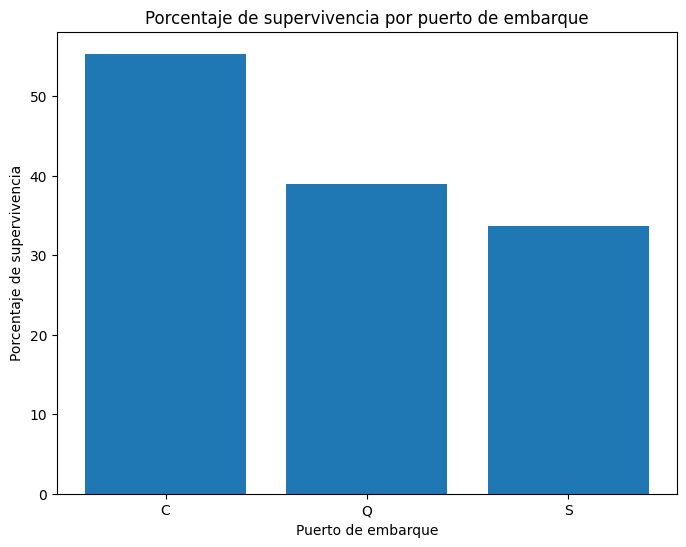

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64


In [8]:
# Agrupar por puerto de embarque y calcular el porcentaje de supervivencia
supervivencia_por_embarque = df.groupby('Embarked')['Survived'].mean() * 100

# Mostrar los resultados
print(supervivencia_por_embarque)

# Crear un gráfico de barras para visualizar la relación
plt.figure(figsize=(8, 6))
plt.bar(supervivencia_por_embarque.index, supervivencia_por_embarque.values)
plt.xlabel('Puerto de embarque')
plt.ylabel('Porcentaje de supervivencia')
plt.title('Porcentaje de supervivencia por puerto de embarque')
plt.show()
# Agrupar por puerto de embarque y contar la cantidad de sobrevivientes
sobrevivientes_por_puerto = df.groupby('Embarked')['Survived'].sum()

# Mostrar los resultados
print(sobrevivientes_por_puerto)

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64


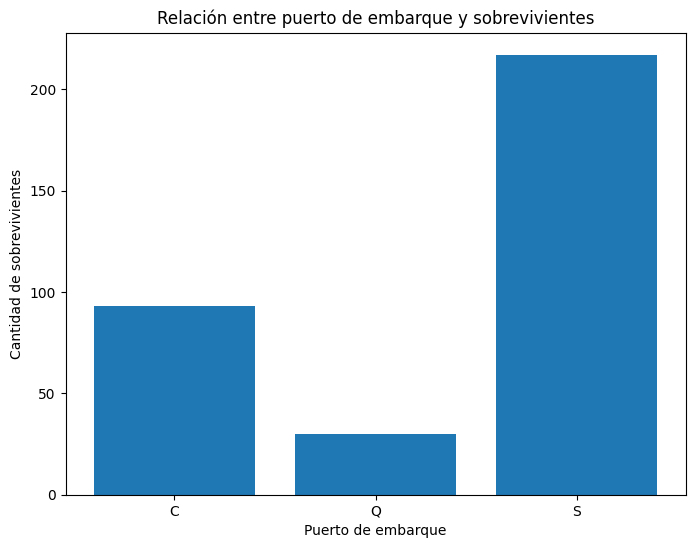

In [9]:
# Agrupar por puerto de embarque y contar la cantidad de sobrevivientes
survivors_by_embarked = df.groupby('Embarked')['Survived'].sum()

# Mostrar los resultados
print(survivors_by_embarked)

# Crear un gráfico de barras para visualizar la relación
plt.figure(figsize=(8, 6))
plt.bar(survivors_by_embarked.index, survivors_by_embarked.values)
plt.xlabel('Puerto de embarque')
plt.ylabel('Cantidad de sobrevivientes')
plt.title('Relación entre puerto de embarque y sobrevivientes')
plt.show()

En este caso viendo la ubicacion de los pasajeros de primera clase y la ubicacion de los botes salvavidas, seria lo mas normal que las personas de primera clase, es decir, con mas poder adquisitivo sobrevivan. Ademas por el lugar en el que colisiono el titanic, se ve que los pasajeros de 3ra clase y la crew fueron los primeros en inundarse


Hay un total de 20 botes salvavidas, los cuales estaban diseñádos para albergar a 65 personas cada uno, lo que nos da un total de personas de 1300, entonces, podemos saber que los botes no fueron al 100% de capacidad debido a que solo sobrevivieron 712 de los 2200 pasajeros en total, habiendole dado a las mujeres y niños la prioridad.

Tambien, el total de personas que PODRIAN haber sido salvadas, era de 1300, asi que se puede deducir que se iba a dar prioridad a personas de clase alta, mujeres y niños

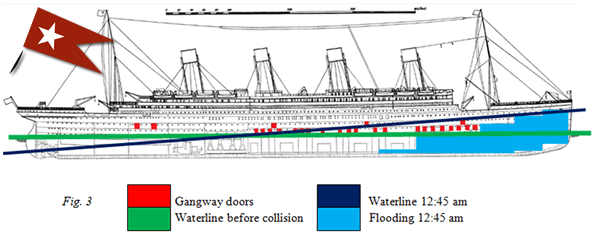

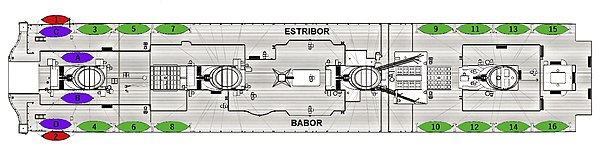

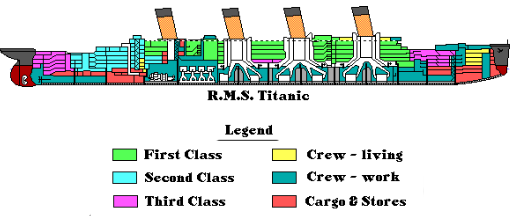


#Reparacion set de datos y ingenieria de vairables ⚙️🛠️


In [10]:
#imputar la edad!
# Calcular la media de edad según sexo, si tiene hijos (SibSp) y clase
# Convertimos SibSp en una columna binaria: 1 si tiene hijos (SibSp > 0), 0 si no
df['Hijos'] = df['Parch'].apply(lambda x: 1 if x > 0 else 0)

# Calcular la media de edad
age_means = df.groupby(['Sex', 'Hijos', 'Pclass'])['Age'].mean().reset_index()#agrupo sexo, hijo, clase, comparandolo con la edad para sacar la media
age_means.columns = ['Sex', 'Hijos', 'Pclass', 'AgeMean']

def imputar_edad(row):
    if pd.isnull(row['Age']):
        # Buscar la media correspondiente en el DataFrame 'age_means'
        return age_means[(age_means['Sex'] == row['Sex']) &
                         (age_means['Hijos'] == (1 if row['Parch'] > 0 else 0)) &
                         (age_means['Pclass'] == row['Pclass'])]['AgeMean'].values[0]
    else:
        return row['Age']

# Imputar los valores faltantes en la columna 'Age'
df['Age'] = df.apply(imputar_edad, axis=1)
df = df.drop('Hijos', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
#junto las columnas sibsp y parch en una sola llamada familia
df['Familia'] = df['SibSp'] + df['Parch'] + 1  # +1 para incluir al mismo pasajero

In [12]:
df['Cuota_por_pasajero'] = df['Fare'] / df['Familia']

In [13]:
#invierto los valores de Pclass, ya que actualmente esta el 3 en tercera clase, y deberia estar en primera
df['Pclass'] = df['Pclass'].replace({1: 3, 3: 1})

In [14]:
def extraer_titulo(nombre):
    #Separar el nombre por comas y luego por puntos
    return nombre.split(',')[1].split('.')[0].strip()

df['Titulo'] = df['Name'].apply(extraer_titulo)

# diccionario para el .map
titulo_map = {
    'Mr': 1, 'Mrs': 2, 'Miss': 3, 'Master': 4, 'Dr': 5, 'Rev': 6,
    'Col': 7, 'Major': 8, 'Sir': 9, 'Jonkheer': 10, 'Don': 11,
    'Lady': 12, 'Capt': 13, 'Countess': 14
}
#Aplicar el mapeo a la nueva columna 'Titulo'
df['Titulo'] = df['Titulo'].map(titulo_map)

#eliminar la columna 'Name'
df = df.drop(['Name'], axis = 1)
#rellenar valores nulos en 'Titulo' con 0
#df['Titulo'].fillna(0, inplace = True)
df.fillna({'Titulo' : 0}, inplace = True)#asi hay que hacerlo a partir de pandas 3.0 (totalmente random)

In [15]:
genero_map = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(genero_map)

#aca quiero crear una columna que sea la clase + el sexo, porque ya sabemos que las mujeres y los clase alta eran las que mas sobrevivieron
df['Pclass_Sex'] = df['Pclass'].astype(str) + df['Sex'].astype(str)

In [16]:
df['Categoria_edad'] = pd.cut(df['Age'], bins=[0, 12, 18, 65, 100], labels=['Niño', 'Adolescente', 'Adulto', 'Anciano'])
edad_map = {'Niño': 4, 'Adolescente': 4, 'Adulto' : 2, 'Anciano' : 1}
df['Categoria_edad'] = df['Categoria_edad'].map(edad_map)
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familia,Cuota_por_pasajero,Titulo,Pclass_Sex,Categoria_edad
0,1,0,1,0,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,1.0,10,2
1,2,1,3,1,38.000000,1,0,PC 17599,71.2833,C85,C,2,35.64165,2.0,31,2
2,3,1,1,1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.92500,3.0,11,2
3,4,1,3,1,35.000000,1,0,113803,53.1000,C123,S,2,26.55000,2.0,31,2
4,5,0,1,0,35.000000,0,0,373450,8.0500,NaN,S,1,8.05000,1.0,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,211536,13.0000,NaN,S,1,13.00000,6.0,20,2
887,888,1,3,1,19.000000,0,0,112053,30.0000,B42,S,1,30.00000,3.0,31,2
888,889,0,1,1,19.197917,1,2,W./C. 6607,23.4500,NaN,S,4,5.86250,3.0,11,2
889,890,1,3,0,26.000000,0,0,111369,30.0000,C148,C,1,30.00000,1.0,30,2


In [17]:
#eliminacion de columans que no aportan valor o columnas ya utilizadas para crear nuevas
df = df.drop(['PassengerId', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Sex', 'Pclass', 'Embarked'], axis = 1)

#Creacion de Modelos 🧠🤖

In [18]:
#mutual information:
X = df.drop(['Survived'], axis  = 1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 123)
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size = 0.30, random_state = 123)


mutual_info = mutual_info_classif(X , y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending = False)

,0
Pclass_Sex,0.206410
Titulo,0.184093
Cuota_por_pasajero,0.150230
Fare,0.141687
Age,0.077649
Familia,0.063914
Categoria_edad,0.017705


##RandomForest 1:

In [19]:
X = df.drop(['Survived'], axis  = 1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 123)
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size = 0.30, random_state = 123)

max_depth = list(range(1, 20, 2))
estimator = list(range(50, 500, 50))
parametros={
    'max_depth':[],
    'estimators':[],
    'Acc':[]
}

for depth in max_depth:
  for est in estimator:
    rf_1 = RandomForestClassifier(
    max_depth = depth,
    random_state = 123,
    n_estimators = est)

    rf_1.fit(X_val_train, y_val_train)
    y_pred_1 = rf_1.predict(X_val_test)
    Acc = accuracy_score(y_val_test, y_pred_1)

    parametros['max_depth'].append(depth)
    parametros['estimators'].append(est)
    parametros['Acc'].append(Acc)

df_parametros = pd.DataFrame(parametros)
df_parametros.sort_values(by = 'Acc', ascending = False)

,max_depth,estimators,Acc
34,7,400,0.850267
33,7,350,0.850267
32,7,300,0.850267
30,7,200,0.850267
29,7,150,0.850267
...,...,...,...
8,1,450,0.764706
3,1,200,0.759358
2,1,150,0.754011
1,1,100,0.737968


In [20]:
#guardado rf_1 (85% ACC)

rf_1_guardado = RandomForestClassifier(n_estimators = 400 , max_depth = 7, random_state = 123)
rf_1_guardado.fit(X, y)

with open('rf_1.plk', 'wb') as file:
    pickle.dump(rf_1_guardado, file)
files.download('rf_1.plk')
print("Modelo entrenado con el 100% de los datos y guardado con éxito.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo entrenado con el 100% de los datos y guardado con éxito.


##RandomForest 2:

In [21]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Crear un DataFrame con los sobrevivientes y los fallecidos
df_survived = df[df['Survived'] == 1]
df_dead = df[df['Survived'] == 0]

# Aplicar transformaciones matemáticas a los sobrevivientes
df_survived_mult = df_survived.copy()
df_survived_mult[['Age', 'Fare']] = df_survived_mult[['Age', 'Fare']] * 1.2  # Multiplicar por un factor

df_survived_sqrt = df_survived.copy()
df_survived_sqrt[['Age', 'Fare']] = np.sqrt(df_survived_sqrt[['Age', 'Fare']])  # Aplicar raíz cuadrada

df_survived_pow = df_survived.copy()
df_survived_pow[['Age', 'Fare']] = np.power(df_survived_pow[['Age', 'Fare']], 1.5)  # Aplicar potencia

# Concatenar las nuevas filas transformadas
df_survived_transformed = pd.concat([df_survived, df_survived_mult, df_survived_sqrt, df_survived_pow])

# Re-muestrear para tener 2000 sobrevivientes
df_survived_balanced = resample(df_survived_transformed, replace=True, n_samples=2000, random_state=42)

# Aplicar transformaciones matemáticas a los fallecidos
df_dead_mult = df_dead.copy()
df_dead_mult[['Age', 'Fare']] = df_dead_mult[['Age', 'Fare']] * 1.2  # Multiplicar por un factor

df_dead_sqrt = df_dead.copy()
df_dead_sqrt[['Age', 'Fare']] = np.sqrt(df_dead_sqrt[['Age', 'Fare']])  # Aplicar raíz cuadrada

df_dead_pow = df_dead.copy()
df_dead_pow[['Age', 'Fare']] = np.power(df_dead_pow[['Age', 'Fare']], 1.5)  # Aplicar potencia

# Concatenar las nuevas filas transformadas
df_dead_transformed = pd.concat([df_dead, df_dead_mult, df_dead_sqrt, df_dead_pow])

# Re-muestrear para tener 2000 fallecidos
df_dead_balanced = resample(df_dead_transformed, replace=True, n_samples=2000, random_state=42)

# Crear el DataFrame final con 2000 sobrevivientes y 2000 fallecidos
df_balanced = pd.concat([df_survived_balanced, df_dead_balanced])

# Verificar que ahora ambos grupos tengan 2000 muestras
print(df_balanced['Survived'].value_counts())


Survived
1    2000
0    2000
Name: count, dtype: int64


In [22]:
# Crear el DataFrame final con 2000 sobrevivientes y 2000 fallecidos
df_multiplicado = pd.concat([df_survived_balanced, df_dead_balanced])

# Verificar que el DataFrame tenga las 4000 muestras
print(df_multiplicado.shape)  # Esto debería mostrar (4000, columnas)

# Opcional: Verificar la distribución de la columna 'Survived' para asegurarte de que ambos tengan 2000 muestras
print(df_multiplicado['Survived'].value_counts())


(4000, 8)
Survived
1    2000
0    2000
Name: count, dtype: int64


In [23]:
import pandas as pd
import numpy as np

# Cargar tu dataset
# df = pd.read_csv('ruta_a_tu_archivo.csv')

# Agrupar los datos por 'Pclass_Sex' y 'Survived'
grouped = df.groupby(['Pclass_Sex', 'Survived']).size().unstack(fill_value=0)

# Crear un nuevo DataFrame para almacenar las muestras equilibradas
balanced_samples = []

# Iterar sobre cada combinación de Pclass_Sex
for pclass_sex, row in grouped.iterrows():
    n_alive = row[1]  # Número de sobrevivientes
    n_dead = row[0]   # Número de no sobrevivientes

    # Determinar el número máximo de muestras para equilibrar
    max_samples = max(n_alive, n_dead)

    # Extraer las filas correspondientes de df
    if n_alive < max_samples:
        # Aumentar los sobrevivientes
        alive_samples = df[(df['Pclass_Sex'] == pclass_sex) & (df['Survived'] == 1)]
        alive_samples = alive_samples.sample(max_samples, replace=True)
    else:
        alive_samples = df[(df['Pclass_Sex'] == pclass_sex) & (df['Survived'] == 1)]

    if n_dead < max_samples:
        # Aumentar los no sobrevivientes
        dead_samples = df[(df['Pclass_Sex'] == pclass_sex) & (df['Survived'] == 0)]
        dead_samples = dead_samples.sample(max_samples, replace=True)
    else:
        dead_samples = df[(df['Pclass_Sex'] == pclass_sex) & (df['Survived'] == 0)]

    # Combinar las muestras equilibradas
    balanced_samples.append(alive_samples)
    balanced_samples.append(dead_samples)

# Concatenar todas las muestras equilibradas en un único DataFrame
balanced_df = pd.concat(balanced_samples).reset_index(drop=True)

# Mostrar el resultado equilibrado
print(balanced_df.groupby(['Pclass_Sex', 'Survived']).size())


Pclass_Sex  Survived
10          0           300
            1           300
11          0            72
            1            72
20          0            91
            1            91
21          0            70
            1            70
30          0            77
            1            77
31          0            91
            1            91
dtype: int64


In [24]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Cargar tu dataset
# df = pd.read_csv('ruta_a_tu_archivo.csv')

# Crear un DataFrame con los sobrevivientes y los fallecidos
df_survived = df[df['Survived'] == 1]
df_dead = df[df['Survived'] == 0]

# Aplicar transformaciones matemáticas a los sobrevivientes
df_survived_mult = df_survived.copy()
df_survived_mult[['Age', 'Fare']] *= 1.2  # Multiplicar por un factor

df_survived_sqrt = df_survived.copy()
df_survived_sqrt[['Age', 'Fare']] = np.sqrt(df_survived_sqrt[['Age', 'Fare']])  # Aplicar raíz cuadrada

df_survived_pow = df_survived.copy()
df_survived_pow[['Age', 'Fare']] = np.power(df_survived_pow[['Age', 'Fare']], 1.5)  # Aplicar potencia

# Concatenar las nuevas filas transformadas
df_survived_transformed = pd.concat([df_survived, df_survived_mult, df_survived_sqrt, df_survived_pow])

# Re-muestrear para tener 2000 sobrevivientes
df_survived_balanced = resample(df_survived_transformed, replace=True, n_samples=2000, random_state=42)

# Aplicar transformaciones matemáticas a los fallecidos
df_dead_mult = df_dead.copy()
df_dead_mult[['Age', 'Fare']] *= 1.2  # Multiplicar por un factor

df_dead_sqrt = df_dead.copy()
df_dead_sqrt[['Age', 'Fare']] = np.sqrt(df_dead_sqrt[['Age', 'Fare']])  # Aplicar raíz cuadrada

df_dead_pow = df_dead.copy()
df_dead_pow[['Age', 'Fare']] = np.power(df_dead_pow[['Age', 'Fare']], 1.5)  # Aplicar potencia

# Concatenar las nuevas filas transformadas
df_dead_transformed = pd.concat([df_dead, df_dead_mult, df_dead_sqrt, df_dead_pow])

# Re-muestrear para tener 2000 fallecidos
df_dead_balanced = resample(df_dead_transformed, replace=True, n_samples=2000, random_state=42)

# Crear un DataFrame final con 2000 sobrevivientes y 2000 fallecidos
df_balanced = pd.concat([df_survived_balanced, df_dead_balanced]).reset_index(drop=True)

# Crear el DataFrame final con las columnas a equilibrar
columns_to_balance = ["Pclass_Sex", "Categoria_edad"]

# Crear un nuevo DataFrame para almacenar las muestras equilibradas
final_balanced_samples = []

# Iterar sobre cada columna que se desea equilibrar
for column in columns_to_balance:
    # Agrupar los datos por la columna actual y 'Survived'
    grouped = df_balanced.groupby([column, 'Survived']).size().unstack(fill_value=0)

    for category, row in grouped.iterrows():
        n_alive = row[1]  # Número de sobrevivientes
        n_dead = row[0]   # Número de no sobrevivientes

        # Determinar el número máximo de muestras para equilibrar
        max_samples = max(n_alive, n_dead)

        # Extraer las filas correspondientes de df_balanced
        alive_samples = df_balanced[(df_balanced[column] == category) & (df_balanced['Survived'] == 1)]
        dead_samples = df_balanced[(df_balanced[column] == category) & (df_balanced['Survived'] == 0)]

        if n_alive < max_samples:
            alive_samples = alive_samples.sample(max_samples, replace=True)
        if n_dead < max_samples:
            dead_samples = dead_samples.sample(max_samples, replace=True)

        # Combinar las muestras equilibradas
        final_balanced_samples.append(alive_samples)
        final_balanced_samples.append(dead_samples)

# Concatenar todas las muestras equilibradas en un único DataFrame
df_finalisimo = pd.concat(final_balanced_samples).reset_index(drop=True)

# Verificar el DataFrame final
print(df_finalisimo.groupby('Survived').size())
print(df_finalisimo.shape)
df_finalisimo

Survived
0    5241
1    5241
dtype: int64
(10482, 8)


,Survived,Age,Fare,Familia,Cuota_por_pasajero,Titulo,Pclass_Sex,Categoria_edad
0,1,0.648074,2.918339,2,4.258350,4.0,10,4
1,1,24.000000,18.890040,3,5.247233,1.0,10,2
2,1,30.000000,9.500000,1,9.500000,1.0,10,2
3,1,14.400000,13.490040,2,5.620850,4.0,10,4
4,1,19.200000,9.660000,1,8.050000,1.0,10,4
...,...,...,...,...,...,...,...,...
10477,0,22.627417,96.750089,5,4.215000,3.0,11,4
10478,0,13.200000,37.530000,7,4.467857,3.0,11,4
10479,0,59.440123,580.023649,11,6.322727,4.0,10,4
10480,0,3.902653,8.339664,11,6.322727,1.0,10,4


In [25]:
X_finalisimo = df_finalisimo.drop(['Survived'], axis  = 1)
y_finalisimo = df_finalisimo['Survived']
X_train_finalisimo, X_test_finalisimo, y_train_finalisimo, y_test_finalisimo = train_test_split(X_finalisimo, y_finalisimo, test_size = 0.30, random_state = 123)
X_val_train_finalisimo, X_val_test_finalisimo, y_val_train_finalisimo, y_val_test_finalisimo = train_test_split(X_train_finalisimo, y_train_finalisimo, test_size = 0.30, random_state = 123)
max_depth = list(range(1, 20, 2))
estimator = list(range(50, 500, 50))
parametros={
    'max_depth':[],
    'estimators':[],
    'Acc':[]
}

for depth in max_depth:
  for est in estimator:
    rf_2 = RandomForestClassifier(
    max_depth = depth,
    random_state = 123,
    n_estimators = est)

    rf_2.fit(X_val_train_finalisimo, y_val_train_finalisimo)
    y_pred_rf_2 = rf_2.predict(X_val_test_finalisimo)
    Acc = accuracy_score(y_val_test_finalisimo, y_pred_rf_2)

    parametros['max_depth'].append(depth)
    parametros['estimators'].append(est)
    parametros['Acc'].append(Acc)

df_parametros = pd.DataFrame(parametros)
df_parametros.sort_values(by = 'Acc', ascending = False)
#mejor modelo: 19 de profundidad 400 estimadores : 97% acertividad

,max_depth,estimators,Acc
83,19,150,0.971844
89,19,450,0.971390
88,19,400,0.971390
87,19,350,0.971390
85,19,250,0.971390
...,...,...,...
0,1,50,0.676658
6,1,350,0.676658
7,1,400,0.676658
8,1,450,0.676658


In [26]:
#creo un mutual info
mutual_info_con_ingenieria = mutual_info_classif(X_finalisimo , y_finalisimo)
mutual_info_con_ingenieria = pd.Series(mutual_info_con_ingenieria)
mutual_info_con_ingenieria.index = X.columns
mutual_info_con_ingenieria.sort_values(ascending = False)

,0
Cuota_por_pasajero,0.343067
Fare,0.322307
Age,0.129330
Titulo,0.053439
Familia,0.030996
Pclass_Sex,0.024399
Categoria_edad,0.001713


In [27]:
rf_2 = RandomForestClassifier(n_estimators = 100 , max_depth = 19, random_state = 123)
rf_2.fit(X_finalisimo, y_finalisimo)

with open('rf_2.plk', 'wb') as file:
    pickle.dump(rf_2, file)
files.download('rf_2.plk')
print("Modelo entrenado con el 100% de los datos y guardado con éxito.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo entrenado con el 100% de los datos y guardado con éxito.


Aca si bien obtuve un gran acc gracias a la ingenieria de variable hecha en el bloque llamado "RandomForest 2", pensando que era un gran modelo y que a la hora de ponerlo en produccion iba a tener resultados aunque sea similares, no fue asi, a la hora de poner el modelo a producir note un gran decaimiento en mi tasa de ACC lo que me daba el indicio (que ya de por si sospechaba por el 97% de acc) de que mi modelo estaba super overfiteado

##RandomForest 3:

In [28]:
data = df

X = data.drop('Survived', axis = 1)
y = data['Survived']

#veo como estaba antes del oversampler
print("Distribución de clases antes del sobremuestreo:")
print(y.value_counts())

#aplico oversampler
ros = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = ros.fit_resample(X, y)

#resultado final
print("\nDistribución de clases después del sobremuestreo:")
print(y_resampled.value_counts())

#divisdo ddatos voersampler
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 123)
X_val_train_ros, X_val_test_ros, y_val_train_ros, y_val_test_ros = train_test_split(X_train_ros, y_train_ros, test_size=0.2, random_state = 123)

max_depth = list(range(1, 20, 2))
estimator = list(range(50, 500, 50))
parametros={
    'max_depth':[],
    'estimators':[],
    'Acc':[]
}

for depth in max_depth:
  for est in estimator:
    rf_3 = RandomForestClassifier(
    max_depth = depth,
    random_state = 123,
    n_estimators = est)

    rf_3.fit(X_val_train_ros, y_val_train_ros)
    y_pred_rf_3 = rf_3.predict(X_val_test_ros)
    Acc = accuracy_score(y_val_test_ros, y_pred_rf_3)

    parametros['max_depth'].append(depth)
    parametros['estimators'].append(est)
    parametros['Acc'].append(Acc)

df_parametros = pd.DataFrame(parametros)
df_parametros.sort_values(by = 'Acc', ascending = False)




Distribución de clases antes del sobremuestreo:
Survived
0    549
1    342
Name: count, dtype: int64

Distribución de clases después del sobremuestreo:
Survived
0    549
1    549
Name: count, dtype: int64


,max_depth,estimators,Acc
59,13,300,0.835227
60,13,350,0.835227
45,11,50,0.829545
68,15,300,0.829545
56,13,150,0.829545
...,...,...,...
4,1,250,0.721591
2,1,150,0.710227
3,1,200,0.710227
1,1,100,0.681818


In [29]:
rf_3 = RandomForestClassifier(n_estimators = 300 , max_depth = 13, random_state = 123)
rf_3.fit(X_resampled, y_resampled)

with open('rf_3.pkl', 'wb') as file:
    pickle.dump(rf_3, file)
files.download('rf_3.pkl')
print("Modelo entrenado con el 100% de los datos y guardado con éxito.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo entrenado con el 100% de los datos y guardado con éxito.


En este caso el modelo obtuvo un 83.5% de acc, lo cual es un buen numero. La parte mala de este modelo, es que para quilibrar el set de datos utilice una tecnica llamada random over sampling, que basicamente exiende la cantidad de muestras que falten para equilibrar la variable objetivo, en este caso el modelo agrega personas que hayan sobrevivido, para que el modelo este dividido 50% vivosy 590% muertos. Esto esta bueno ya que hace que el modelo no haga una prediccion de porcentaje y simplemente diga bueno, si el 80% murieron tipo 8/10 veces que murio, lograndoq ue el modelo sea realmente predictivo, lo malo es que el modelo fue entrenado con datos del oversampler los cuales no son datos reales, sino que son datos creados y por ende probablemente poco fieles a la realidad